In [ ]:
%%bash
mothur "#sub.sample(fasta=/var/seq_data/RDP_warcup_ITS_db/Warcup.fungalITS.fasta, size=10000)"

In [ ]:
! head /var/seq_data/RDP_warcup_ITS_db/Warcup.fungalITS.subsample.fasta

In [ ]:
! head data/ITS_primers.txt

In [ ]:
%%bash
mothur "#pcr.seqs(fasta=/var/seq_data/RDP_warcup_ITS_db/Warcup.fungalITS.subsample.fasta, \
oligos=data/ITS_primers.txt, pdiffs=6)" > /dev/null

In [ ]:
! head /var/seq_data/RDP_warcup_ITS_db/Warcup.fungalITS.subsample.pcr.fasta

In [28]:
! grep -c ">" /var/seq_data/RDP_warcup_ITS_db/Warcup.fungalITS.subsample.pcr.fasta

3627


In [ ]:
! grep -c ">" /var/seq_data/RDP_warcup_ITS_db/Warcup.fungalITS.subsample.scrap.pcr.fasta

In [ ]:
! head /var/seq_data/RDP_warcup_ITS_db/Warcup.fungalITS.subsample.scrap.pcr.fasta

In [ ]:
! cat  /var/seq_data/RDP_warcup_ITS_db/Warcup.fungalITS.subsample.pcr.fasta data/SIP_Bulk_otusn_l2fc.fasta > data/rep_set_andPick.fasta

In [29]:
! grep -c ">" data/rep_set_andPick.fasta

8330


In [ ]:
%%bash
mothur "#pairwise.seqs(fasta=data/rep_set_andPick.fasta, calc=onegap, countends=false, \
processors=10, output=square)" > /dev/null

In [ ]:
import numpy as np
import matplotlib as mp
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from math import log
from numpy import array
import sys
import re

In [ ]:
%matplotlib inline

In [ ]:
dist_lines = open("data/rep_set_andPick.square.dist").readlines()
def line2array(line):
    line = line.rstrip()
    return np.array(map(float, line.split("\t")[1:]))
distmat = np.vstack([line2array(line) for line in dist_lines[1:]])

In [ ]:
distmat

In [ ]:
def getacc(line):
    line = line.rstrip()
    return np.array(line.split("\t")[0:1])
acc= np.vstack(getacc(line) for line in dist_lines[1:])

In [ ]:
acc2 = np.char.rstrip(acc, ' ')

In [ ]:
distc = np.concatenate((distmat, acc2), axis = 1)

In [ ]:
distc

In [ ]:
tax = open("/var/seq_data/RDP_warcup_ITS_db/Warcup.fungalITS.uclustFMT.tax.txt").readlines()
def line2array(line):
    line = line.rstrip()
    return np.array(map(str, line.split(";")[0:]))
newtax = np.vstack([line2array(line) for line in tax[0:]])

In [ ]:
newtax

In [ ]:
def corr(a):
    if (a >= 0.75): return a
    else: return (-3/4*(log(1-(4/3*a))))

In [ ]:
vecfunc = np.vectorize(corr)
result=vecfunc(distmat)

In [ ]:
print result

In [ ]:
model = TSNE(n_components=2, random_state=0, perplexity = 30)
tsne_coords = model.fit_transform(result) 

In [ ]:
print tsne_coords

In [ ]:
combo = np.concatenate((tsne_coords, acc), axis = 1)

In [ ]:
print combo

In [ ]:
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(frameon=False)
plt.setp(ax, xticks=(), yticks=())
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=0.9,
                wspace=0.0, hspace=0.0)
plt.scatter(combo[:, 0], combo[:, 1])

In [2]:
%load_ext rpy2.ipython

In [3]:
%%R
library(phyloseq)
library(ggplot2)
library(foreach)
library(doParallel)
library(gridExtra)
library(vegan)
library(plyr); library(dplyr)
library(RColorBrewer)
library(stats)
library(reshape2)

/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: foreach: simple, scalable parallel programming from Revolution Analytics
Use Revolution R for scalability, fault tolerance and more.
http://www.revolutionanalytics.com

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required package: iterators

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required package: parallel

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required package: permute

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required package: lattic

In [ ]:
%Rpush combo

In [ ]:
%Rpush distc

In [ ]:
%Rpush newtax

In [ ]:
%%R
dis = as.data.frame(distc)

In [ ]:
%%R
tax = as.data.frame(newtax, stringsAsFactors=FALSE)

In [ ]:
%%R
tax$V1 = substring(tax$V1, 1, 8)
head(tax)


In [ ]:
%%R
colnames(tax) = c("accession","kingdom", "phylum", "subphylum", "class", "subclass", "order", "family", "genus", "species")

In [ ]:
%%R
head(tax)

In [ ]:
%%R
colnames(combo) = c("tsne_1", "tsne_2", "accession")
combo = as.data.frame(combo)
combo$accession = gsub(" ", "", combo$accession, fixed = TRUE)

In [ ]:
%%R
tail(combo)

In [ ]:
%%R
str(combo)

In [ ]:
%%R
d = left_join(combo, tax)

In [ ]:
%%R
length(d$accession)

In [ ]:
%%R
OTUs = filter(d, grepl("OTU",accession))
length(OTUs$accession)

In [ ]:
%%R
OTUs$OTU = OTUs$accession

In [24]:
%%R
l2fc = read.csv("data/l2fc_UNITE.csv", header = TRUE, sep = ",")

In [ ]:
%%R
l2fc2 = l2fc %>% group_by(OTU, Rank1, Rank2, Rank3, Rank4, Rank5, Rank6, Rank7) %>% summarise(minp = min(padj))

In [ ]:
%%R
length(l2fc2$OTU)

In [ ]:
%%R
OTUs_wacc = left_join(OTUs, l2fc2)
length(OTUs_wacc$OTU)

In [ ]:
%%R
head(OTUs_wacc)

In [ ]:
%%R
repset = filter(d, !(grepl("OTU",accession)))

In [ ]:
%%R
OTUs_wacc$kingdom = OTUs_wacc$Rank1
OTUs_wacc$phylum = OTUs_wacc$Rank2
#OTUs_wacc$subphylum = OTUs_wacc$Rank1
OTUs_wacc$class = OTUs_wacc$Rank3
OTUs_wacc$order = OTUs_wacc$Rank4
OTUs_wacc$family = OTUs_wacc$Rank5
OTUs_wacc$genus = OTUs_wacc$Rank6
OTUs_wacc$species = OTUs_wacc$Rank7

In [ ]:
%%R
tail(OTUs_wacc)

In [ ]:
%%R
OTUs_wacc2 = OTUs_wacc %>% select(tsne_1:OTU, minp)
OTUs_wacc2$set = "Experiment"
head(OTUs_wacc2)

In [ ]:
%%R
head(repset)

In [ ]:
%%R
repset$minp = NA
repset$OTU = NA
repset2 = select(repset, tsne_1:species, OTU, minp)
repset2$set = "repset"
head(repset2)

In [ ]:
%%R
both = rbind(OTUs_wacc2, repset2)

In [ ]:
%%R
head(both)

In [ ]:
%%R
write.table(both, "data/tSNE_expRepset.csv", row.names = FALSE, sep = ",")

## Start here if just visualizing t-SNE Coordinates with Metadata

In [ ]:
%load_ext rpy2.ipython

In [ ]:
%%R
library(phyloseq)
library(ggplot2)
library(foreach)
library(doParallel)
library(gridExtra)
library(vegan)
library(plyr); library(dplyr)
library(RColorBrewer)
library(stats)
library(reshape2)

In [4]:
%%R
both = read.csv("data/tSNE_expRepset.csv")

In [5]:
%%R

na = filter(both, is.na(class))
rest = filter(both, !is.na(class))
na$group = "Unclassified"
rest$group = rest$class
both2 = rbind(na, rest)

In [31]:
%%R
both2$Resp_status[both2$minp > 0.10] = "Non-responder"
both2$Resp_status[both2$minp <= 0.10] = "Responder"
both2$Resp_status[is.na(both2$minp)] = "Non-responder"

In [32]:
%%R 
length(both2$OTU)

[1] 8330


In [33]:
%%R
Resp = filter(both2, Resp_status == "Responder")
length(Resp$OTU)

[1] 161


In [7]:
%%R
comp_all = both %>%
group_by(class) %>%
summarise(counts = n())

In [8]:
%%R
comp_all

Source: local data frame [33 x 2]

                                         class counts
                                        (fctr)  (int)
1                               Agaricomycetes    920
2                         Agaricostilbomycetes      5
3                              Arthoniomycetes      5
4  Basidiomycota_Incertae sedis_Incertae sedis      4
5                             Chytridiomycetes     10
6                          Cystobasidiomycetes      1
7                                 Dacrymycetes      4
8                              Dothideomycetes    347
9         Entomophthoromycotina_Incertae sedis      5
10                              Eurotiomycetes    134
..                                         ...    ...


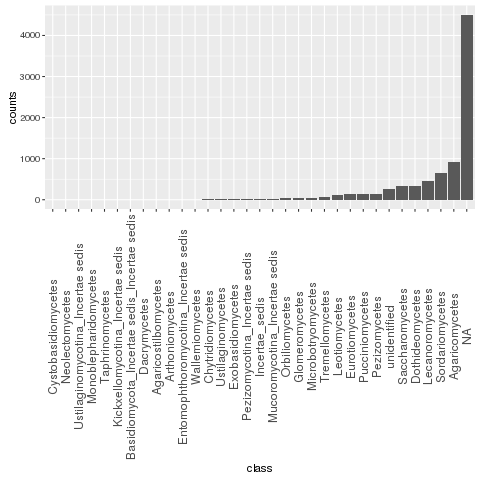

In [9]:
%%R
comp_all$class <- factor(comp_all$class, levels = comp_all$class[order(comp_all$counts)])
p = ggplot(comp_all, aes(x = class, y = counts)) + geom_bar(stat = "identity")
p = p + theme(axis.text.x  = element_text(angle=90, vjust=0.5, size=12))
p

In [ ]:
%%R
a = (arrange(comp_all, desc(counts)))

In [ ]:
%%R
tail(a, n = 20)

In [ ]:
%%R
comp_select = filter(comp_all, counts >30)

In [ ]:
%%R
c = comp_select$class

In [ ]:
%%R
d_filt = filter(both, class %in% c)

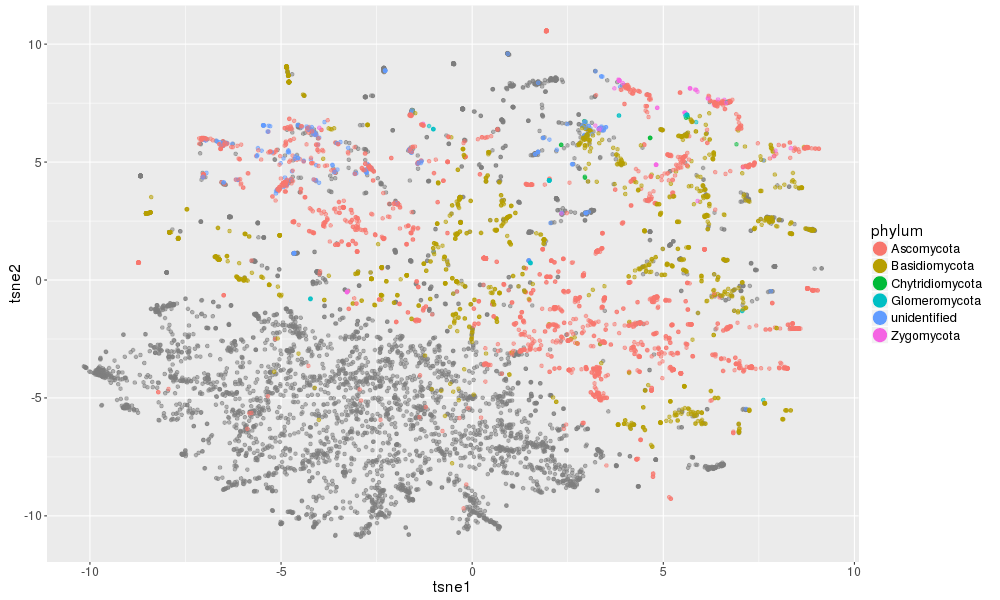

In [114]:
%%R -w 1000 -h 600

asNumeric = function(x) { as.numeric(as.character(x)) }
p = ggplot(both2, aes(x = asNumeric(tsne_1), y = asNumeric(tsne_2)))+
    geom_point(aes(fill = phylum, color = phylum, alpha = 0.85), pch = 21) +
    guides(alpha = FALSE, fill=guide_legend(override.aes=list(size=6))) + labs(size = "Density")+ 
    theme(text = element_text(size=16))  

#p = p + scale_colour_manual(values = pal)
#p = p + scale_fill_manual(values = pal)

p = p + xlab("tsne1") + ylab("tsne2") 

p  

In [125]:
%%R
pal = c("#E7B13C",
"#CC51D1",
"#6ECED3",
"#6E2533",
"#5FE045",
"#406A26",
"#D73F25",
"#4D5284",
"#D1B68C",
"#D74386",
"#547572",
"#C98BCE",
"#35351D",
"#62E0AE",
"#BD7B8B",
"#C7C0CF",
"#716CD2",
"#C7D87E",
"#7E3578",
"#6D9CCF",
"#804622",
"#5EA334",
"#D87A2F",
"#3E3042",
"#D2D341",
"#5D9F6E",
"#BADAB6",
"#CC494E",
"#CC8463",
"#78DE7A",
"#9E8D32",
"#706D3E",
"#AFE43A")

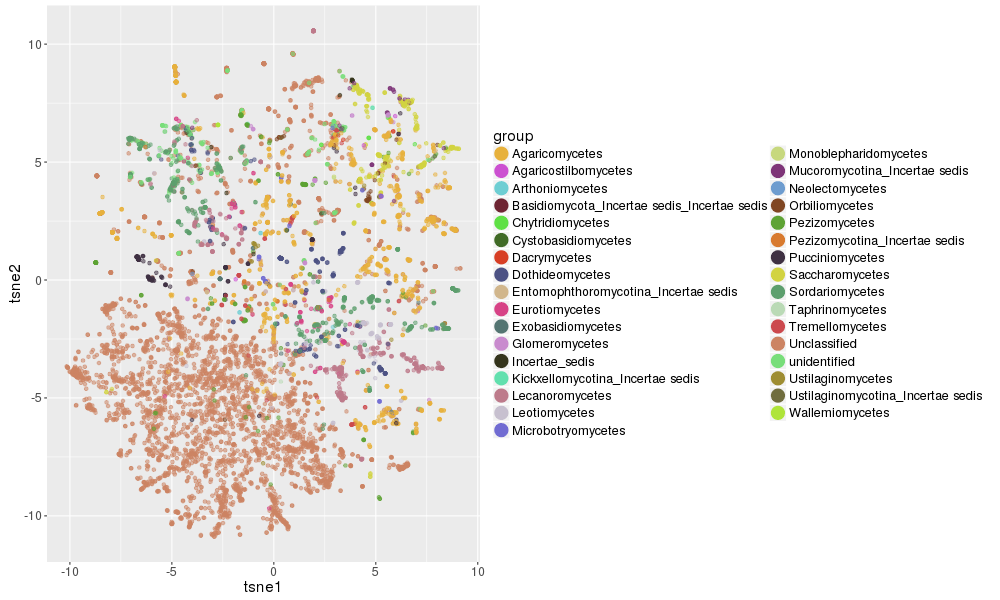

In [126]:
%%R -w 1000 -h 600

#exp = filter(both2, set == "Experiment")
asNumeric = function(x) { as.numeric(as.character(x)) }
p = ggplot(both2, aes(x = asNumeric(tsne_1), y = asNumeric(tsne_2)))+
    geom_point(aes(fill = group, color = group, alpha = 0.85), pch = 21) +
    guides(alpha = FALSE, fill=guide_legend(override.aes=list(size=6))) + labs(size = "Density")+
    theme(text = element_text(size=16)) 

p = p + scale_colour_manual(values = pal)
p = p + scale_fill_manual(values = pal)

p = p + xlab("tsne1") + ylab("tsne2") 

p  

In [108]:
%%R
length(unique(both2$group))

[1] 33


In [ ]:
%%R
ggsave("data/figs/tnseTest_class.pdf", p, height = 7, width = 10)

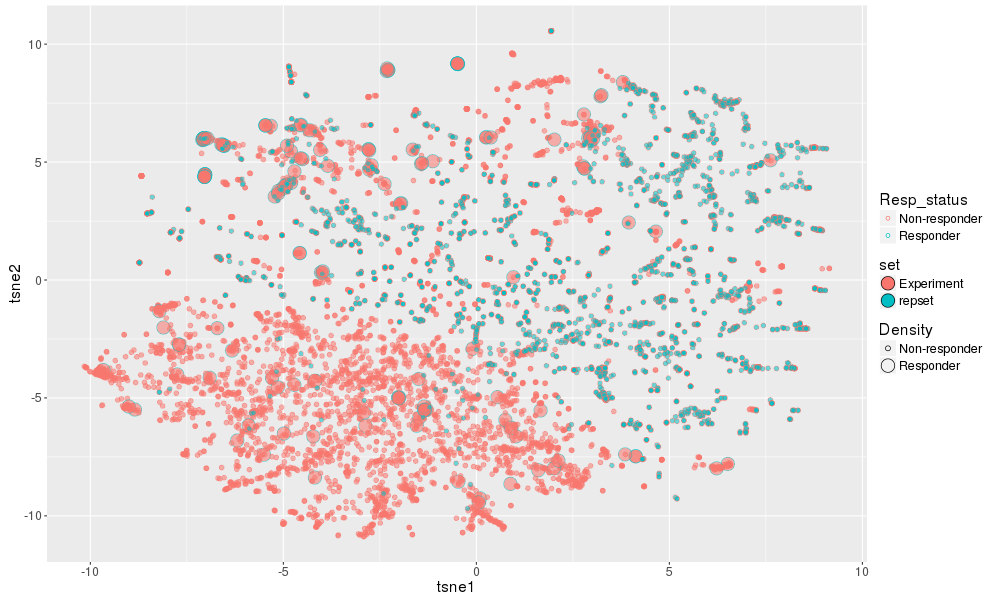

In [37]:
%%R -w 1000 -h 600

asNumeric = function(x) { as.numeric(as.character(x)) }
p = ggplot(both2, aes(x = asNumeric(tsne_1), y = asNumeric(tsne_2)))+
    geom_point(aes(fill = set, color = Resp_status, size = Resp_status, alpha = 0.85), pch = 21) +
    guides(alpha = FALSE, fill=guide_legend(override.aes=list(size=6))) + labs(size = "Density")+
    theme(text = element_text(size=16)) 

p = p + xlab("tsne1") + ylab("tsne2") 

p  

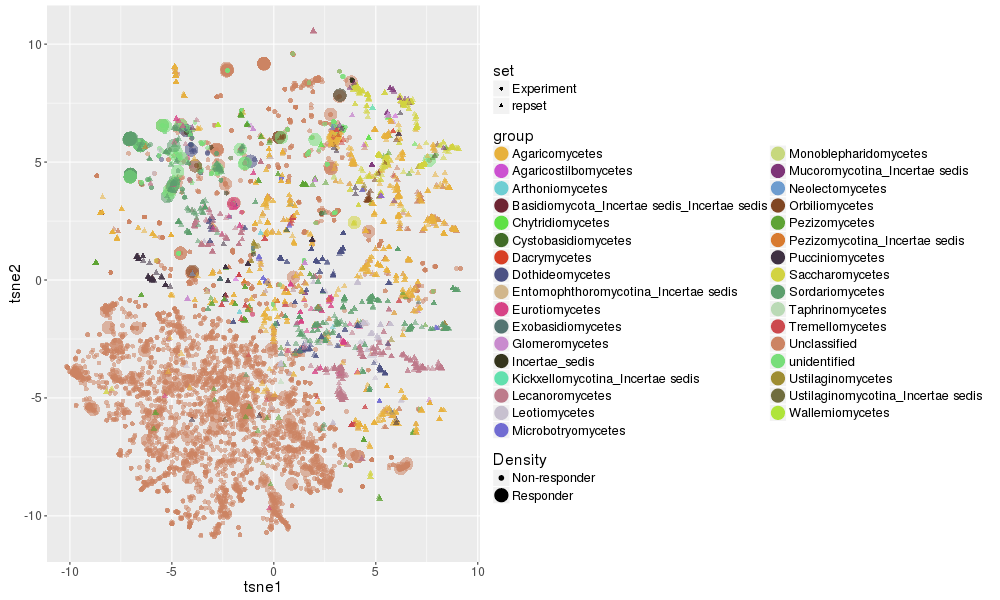

In [127]:
%%R -w 1000 -h 600

asNumeric = function(x) { as.numeric(as.character(x)) }
p = ggplot(both2, aes(x = asNumeric(tsne_1), y = asNumeric(tsne_2)))+
    geom_point(aes(fill = group, color = group, shape = set, size = Resp_status, alpha = 0.85)) +
    guides(alpha = FALSE, fill=guide_legend(override.aes=list(size=6))) + labs(size = "Density")+
    theme(text = element_text(size=16)) 

p = p + scale_colour_manual(values = pal)
p = p + scale_fill_manual(values = pal)

p = p + xlab("tsne1") + ylab("tsne2") 

p  

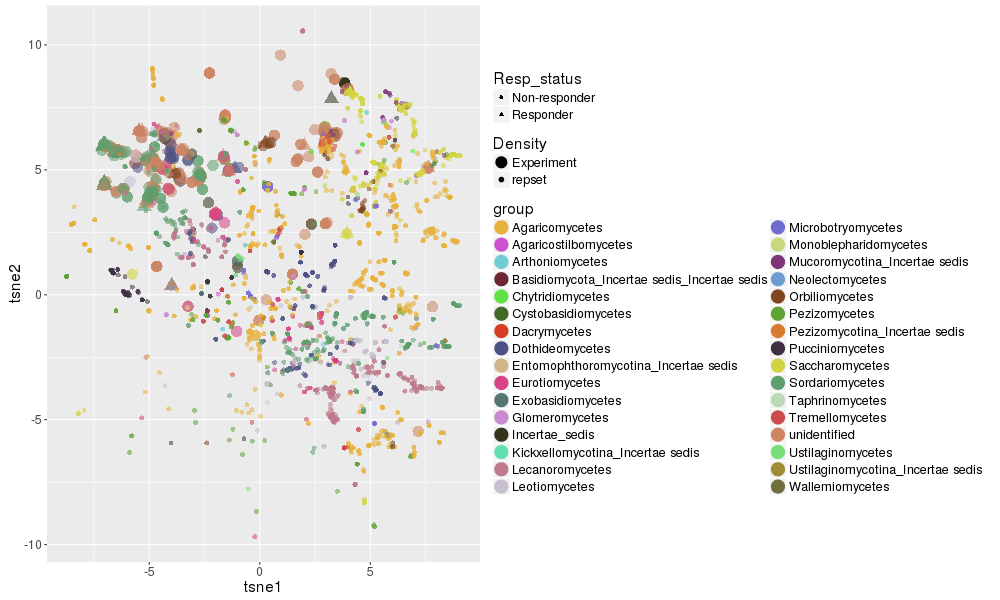

In [128]:
%%R -w 1000 -h 600

nounclass = filter(both2, class != "unclassified")

asNumeric = function(x) { as.numeric(as.character(x)) }
p = ggplot(nounclass, aes(x = asNumeric(tsne_1), y = asNumeric(tsne_2)))+
    geom_point(aes(fill = group, color = group, shape = Resp_status, size = set, alpha = 0.85)) +
    guides(alpha = FALSE, fill=guide_legend(override.aes=list(size=6))) + labs(size = "Density")+
    theme(text = element_text(size=16)) 

p = p + scale_colour_manual(values = pal)
p = p + scale_fill_manual(values = pal)
p = p + scale_size_manual(values = c(5, 2))

p = p + xlab("tsne1") + ylab("tsne2") 

p  

## Looking at closest BLAST matches for "unclassified" responders

In [65]:
%%R
unclass_resp = filter(both2, set == "Experiment", tsne_1 <0, tsne_2 < -5, Resp_status == "Responder")
a = as.matrix((unique(unclass_resp$OTU)))
tail(a)

      [,1]       
[14,] "OTU.4807" 
[15,] "OTU.4816" 
[16,] "OTU.5690" 
[17,] "OTU.19443"
[18,] "OTU.27515"
[19,] "OTU.27602"


In [66]:
%%R
write(a, file = "data/unclassResp_OTUs.txt",
      ncolumns = 1,
      append = FALSE, sep = " ")

In [76]:
! grep -A 1 -wf data/unclassResp_OTUs.txt SIP_Bulk_otusn_soft.fasta > data/SIP_Bulk_otusn_unclassResp.fasta 

In [81]:
! blastall -i data/SIP_Bulk_otusn_unclassResp.fasta -d /var/seq_data/ncbi_db/blastdb/nt -p blastn -b 2 -v 2 

BLASTN 2.2.22 [Sep-27-2009]


Reference: Altschul, Stephen F., Thomas L. Madden, Alejandro A. Schaffer, 
Jinghui Zhang, Zheng Zhang, Webb Miller, and David J. Lipman (1997), 
"Gapped BLAST and PSI-BLAST: a new generation of protein database search
programs",  Nucleic Acids Res. 25:3389-3402.

Query= OTU.65
         (112 letters)

Database: Nucleotide collection (nt) 
           21,474,501 sequences; 54,492,532,053 total letters

Searching..................................................done



                                                                 Score    E
Sequences producing significant alignments:                      (bits) Value

gb|CP002279.1| Mesorhizobium opportunistum WSM2075, complete genome    44   0.26 
gb|CP000358.2| Deinococcus geothermalis DSM 11300 plasmid pDGEO0...    40   4.0  

>gb|CP002279.1| Mesorhizobium opportunistum WSM2075, complete genome
          Length = 6884444

 Score = 44.1 bits (22), Expect = 0.26
 Identities = 22/22 (100%)
 Strand = Plus / 

## Looking BLAST hits of "Unassigned" fungal responders that cluster with other 

In [103]:
%%R
b = filter(both2, set == "Experiment", tsne_2 >= 0, Resp_status == "Responder", kingdom == "Unassigned")
b = as.matrix((unique(b$OTU)))
tail(b)


      [,1]      
[28,] "OTU.2170"
[29,] "OTU.2406"
[30,] "OTU.2409"
[31,] "OTU.2617"
[32,] "OTU.2829"
[33,] "OTU.9248"


In [104]:
%%R
write(b, file = "data/classResp_OTUs.txt",
      ncolumns = 1,
      append = FALSE, sep = " ")

In [105]:
! grep -A 1 -wf data/classResp_OTUs.txt SIP_Bulk_otusn_soft.fasta > data/SIP_Bulk_otusn_classResp.fasta 

In [107]:
! blastall -i data/SIP_Bulk_otusn_classResp.fasta -d /var/seq_data/ncbi_db/blastdb/nt -p blastn -b 2 -v 2 

BLASTN 2.2.22 [Sep-27-2009]


Reference: Altschul, Stephen F., Thomas L. Madden, Alejandro A. Schaffer, 
Jinghui Zhang, Zheng Zhang, Webb Miller, and David J. Lipman (1997), 
"Gapped BLAST and PSI-BLAST: a new generation of protein database search
programs",  Nucleic Acids Res. 25:3389-3402.

Query= OTU.18
         (184 letters)

Database: Nucleotide collection (nt) 
           21,474,501 sequences; 54,492,532,053 total letters

Searching..................................................done



                                                                 Score    E
Sequences producing significant alignments:                      (bits) Value

gb|KF777163.1| Harzia cameroonensis strain CPC 22065 18S ribosom...    84   5e-13
gb|KF361473.1| Uncultured Serenomyces clone Copernicia Miami-Dad...    84   5e-13

>gb|KF777163.1| Harzia cameroonensis strain CPC 22065 18S ribosomal RNA gene,
           partial sequence; internal transcribed spacer 1, 5.8S
           ribosomal RNA gene, and in

## Playing around with Mantel tests of distance matrices

In [ ]:
%%R
library(ape)
library(stats)
#library(Reol)
library(taxize)
library(tidyr)
library(ecodist)

In [ ]:
%%R
data_long <- gather(d_filt, rank, name, kingdom:species)

In [ ]:
%%R
data_long$id = data_long$accession

In [ ]:
%%R
head(data_long)

In [ ]:
%%R
checkdups = filter(data_long, rank == "species" )

In [ ]:
%%R
head(checkdups)

In [ ]:
%%R
filt = checkdups[duplicated(checkdups$name),]

In [ ]:
%%R
length(filt$accession)

In [ ]:
%%R
d_filt2 = filter(d_filt, !(accession %in% filt$accession))

In [ ]:
%%R
pointsdf = select(d_filt2, species, tsne_1, tsne_2)

In [ ]:
%%R
head(pointsdf)

In [ ]:
%%R
points.dist = dist(pointsdf)
points2.dist = as.matrix(points.dist, labels = TRUE)
colnames(points2.dist) <- rownames(points2.dist) <- pointsdf[['species']]

In [ ]:
%%R
pointsdfacc = select(d_filt, accession, tsne_1, tsne_2)

In [ ]:
%%R
pointsacc.dist = dist(pointsdfacc)
points2acc.dist = as.matrix(pointsacc.dist, labels = TRUE)
colnames(points2acc.dist) <- rownames(points2acc.dist) <- pointsdfacc[['accession']]

In [ ]:
%%R
data_long <- gather(d_filt2, rank, name, kingdom:species)

In [ ]:
%%R
data_long$id = data_long$accession

In [ ]:
%%R
data_long2 = select(data_long, name, rank, id)

In [ ]:
%%R
d3 = split(data_long2, list(data_long2$id))

In [ ]:
%%R
head(d3)

In [ ]:
%%R
#Testing whether duplicated species names in table
#p = lapply(d5, table) 

In [ ]:
%%R
#m = lapply(p, as.matrix)
#v = lapply(m, as.vector)

In [ ]:
%%R
#l2 = lapply(v, function(x) any(x>1))

In [ ]:
%%R
#df = do.call(rbind, l2)
#table(df[,1])

In [ ]:
%%R
tr <- class2tree(d3)
plot(tr)

In [ ]:
%%R
str(tr)

In [ ]:
%%R
phy.dist = (tr[["distmat"]])

In [ ]:
%%R
str(phy.dist)

In [ ]:
%%R
phy2.dist = as.matrix(phy.dist, labels = TRUE)
colnames(phy2.dist) <- rownames(phy2.dist) <- attr(phy.dist, "Labels") 

In [ ]:
%%R
phy2.dist <- phy2.dist[rownames(points2.dist),colnames(points2.dist),drop=FALSE]

In [ ]:
%%R
str(dis4.dist)

In [ ]:
%%R
dis4.dist <- dis4.dist[rownames(points2acc.dist),colnames(points2acc.dist),drop=FALSE]

In [ ]:
%%R
str(points2acc.dist)

In [ ]:
%%R
phy3.dist = as.dist(phy2.dist)

In [ ]:
%%R
str(phy3.dist)

In [ ]:
%%R
points3.dist = as.dist(points2.dist)

In [ ]:
%%R
str(points3.dist)

In [ ]:
%%R
mantel(points3.dist ~ phy3.dist, nperm = 1000)

In [ ]:
%%R
points3acc.dist = as.dist(points2acc.dist)
dis5.dist = as.dist(dis4.dist)

In [ ]:
%%R
mantel(points3acc.dist ~ dis5.dist, nperm = 1000)

In [ ]:
%%R
mgram1 = mgram(points3.dist, phy3.dist, nperm = 1000, nboot = 500, pboot = 0.9, cboot = 0.95,
alternative = "two.sided")

In [ ]:
%%R
plot(mgram1, pval = 0.05, xlab = "Distance", ylab = "Mantel r")

In [ ]:
%%R
plot(phy3.dist, points3.dist) + abline(1,1)